
Processing Assets/white-flower.png ...


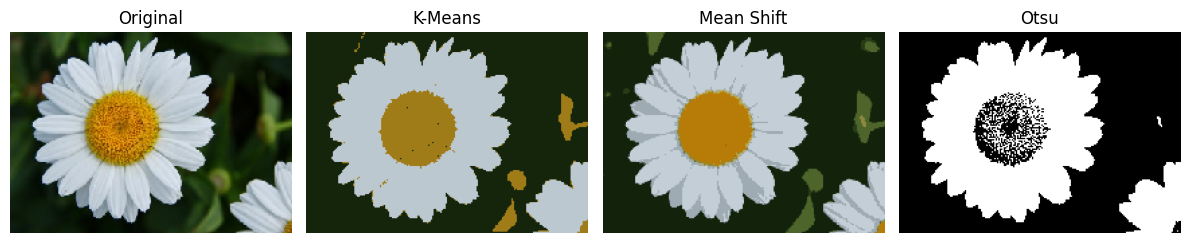


Processing Assets/butterfly.jpg ...


KeyboardInterrupt: 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Load image and convert to NumPy

def load_image(path):
    img = Image.open(path).convert('RGB')
    return np.array(img)

# ---------- K-MEANS (from scratch) ----------
def kmeans_segmentation(image, k=3, max_iters=100):
    h, w, c = image.shape
    data = image.reshape((-1, 3)).astype(float)
    
    # Randomly initialize centroids
    centroids = data[np.random.choice(data.shape[0], k, replace=False)]

    for _ in range(max_iters):
        distances = np.linalg.norm(data[:, None] - centroids, axis=2)
        labels = np.argmin(distances, axis=1)

        new_centroids = np.array([
            data[labels == i].mean(axis=0) if np.any(labels == i) else centroids[i]
            for i in range(k)
        ])
        if np.allclose(centroids, new_centroids):
            break
        centroids = new_centroids

    segmented_data = centroids[labels].reshape((h, w, 3)).astype(np.uint8)
    return segmented_data

# ---------- MEAN SHIFT (Simplified) ----------
def mean_shift_segmentation(image, bandwidth=30, max_iters=10):
    h, w, c = image.shape
    data = image.reshape((-1, 3)).astype(float)
    shifted = data.copy()

    for it in range(max_iters):
        for i in range(len(data)):
            dist = np.linalg.norm(shifted - shifted[i], axis=1)
            mask = dist < bandwidth
            if np.any(mask):
                shifted[i] = shifted[mask].mean(axis=0)

    # Merge close modes
    unique_colors = []
    clustered = []

    for point in shifted:
        found = False
        for center in unique_colors:
            if np.linalg.norm(point - center) < 10:
                clustered.append(center)
                found = True
                break
        if not found:
            unique_colors.append(point)
            clustered.append(point)

    result = np.array(clustered).reshape((h, w, 3)).astype(np.uint8)
    return result

# ---------- OTSU'S THRESHOLDING ----------
def otsu_threshold(image):
    gray = np.mean(image, axis=2).astype(np.uint8)
    hist = np.bincount(gray.flatten(), minlength=256)
    total = gray.size
    current_max, threshold = 0, 0
    sumB, wB, sum1 = 0, 0, np.dot(np.arange(256), hist)

    for t in range(256):
        wB += hist[t]
        if wB == 0:
            continue
        wF = total - wB
        if wF == 0:
            break

        sumB += t * hist[t]
        mB = sumB / wB
        mF = (sum1 - sumB) / wF
        between = wB * wF * (mB - mF) ** 2

        if between > current_max:
            current_max = between
            threshold = t

    binary = (gray > threshold).astype(np.uint8) * 255
    return binary

# ---------- COMPARISON PLOT ----------
def compare_segmentation(image_path):
    print(f"\nProcessing {image_path} ...")
    image = load_image(image_path)

    kmeans_result = kmeans_segmentation(image, k=3)
    meanshift_result = mean_shift_segmentation(image, bandwidth=30)
    otsu_result = otsu_threshold(image)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 4, 1)
    plt.imshow(image)
    plt.title("Original")
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.imshow(kmeans_result)
    plt.title("K-Means")
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(meanshift_result)
    plt.title("Mean Shift")
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.imshow(otsu_result, cmap='gray')
    plt.title("Otsu")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# ---------- RUN ON BOTH IMAGES ----------
compare_segmentation("Assets/white-flower.png")
compare_segmentation("Assets/butterfly.jpg")